This notebook reads the dictionary of training images and gdf of metadata created by getSentinel.ipynb. The data are then used to fine-tune the VGG16 model that has already been pre-trained on ImageNet data.

In [ ]:
try:
  import livelossplot
except ModuleNotFoundError:
  !pip install livelossplot

In [2]:
%load_ext autoreload
%autoreload 2

import sys
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from livelossplot.inputs.keras import PlotLossesCallback

In [3]:
drive.mount('/content/drive')
sys.path.append('/content/drive/MyDrive/Colab Notebooks/')
import utils

Mounted at /content/drive


In [4]:
data_path = "/content/drive/MyDrive/CAFO_data/forTraining/"

with open(f'{data_path}sentinel_images.pickle', 'rb') as f:
    image_dict = pickle.load(f)

metadata = pd.read_pickle(f'{data_path}metadata_gdf.pkl')

In [53]:

images = []
labels = []
metadata_list = []

for idx, image in image_dict.items():

  images.append(image)
  if metadata.loc[idx, 'Farm type'] in ["Pig", "Poultry", "Broiler", "Layer"]:
    labels.append("CAFO")
  elif metadata.loc[idx, 'Farm type'] == "Non-farm":
    labels.append(metadata.loc[idx, 'Farm type'])
  else:
    print(f"Unknown farm type, {metadata.loc[idx, 'Farm type']}")
  metadata_list.append(metadata.loc[idx].to_dict())

# Count the number of categories
n_classes = len(set(labels))
print(f" There are {n_classes} categories: {set(labels)}")

# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
labels = to_categorical(labels, num_classes=len(set(labels)))

# Combine images, labels, and metadata into a DataFrame for shuffling
data = list(zip(images, labels, metadata_list))
df = pd.DataFrame(data, columns=['image', 'label', 'metadata'])

df = df.sample(frac=1, random_state=42).reset_index(drop=True)

 There are 2 categories: {'Non-farm', 'CAFO'}


In [54]:
# Create training, validation, and test datasets

# Split into (training+validation) and test sets (10% for testing)
train_val_df, test_df = train_test_split(df, test_size=0.1, random_state=42)

# Split training + validation into training and validation sets (~20% for val)
train_df, val_df = train_test_split(train_val_df, test_size=0.22,\
                                    random_state=42)

# Extract the split data
X_train = np.array(train_df['image'].tolist())
y_train = np.array(train_df['label'].tolist())

X_val = np.array(val_df['image'].tolist())
y_val = np.array(val_df['label'].tolist())

X_test = np.array(test_df['image'].tolist())
y_test = np.array(test_df['label'].tolist())

# The index of each item in X_train etc. should correspond to the index in
# the appropriate dataframe
metadata_train = pd.json_normalize(train_df['metadata'])
metadata_val = pd.json_normalize(val_df['metadata'])
metadata_test = pd.json_normalize(test_df['metadata'])

# Print the number of training, validation, and test images
print(f"Training set: {X_train.shape[0]} images")
print(f"Validation set: {X_val.shape[0]} images")
print(f"Test set: {X_test.shape[0]} images")

# Keep copies of original data as the arrays can get changed by the data
# generators
X_train_original = np.copy(X_train)
X_val_original = np.copy(X_val)
X_test_original = np.copy(X_test)

Training set: 3926 images
Validation set: 1108 images
Test set: 560 images


In [55]:
# Set up data generators, augmenting training data but not validation + test data

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
    )

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
    )

In [56]:
# Create the model so as to fine-tune only the top 2 (non-convolutional) layers
# This is essentially extracting features and re-learning how to classify based on them

input_shape=X_train.shape[1:]
optimizer=Adam(learning_rate=0.001)
weights_file = None #'/content/drive/MyDrive/CAFO_models/VGG16_step1.keras'

# Load pretrained layers, excluding fully-connected layers
base_model = VGG16(include_top=False,
                  weights='imagenet',
                  input_shape=input_shape)

# Freeze pretrained layers
base_model.trainable = False

# Create new fully-connected layers for classification
top_model = base_model.output
top_model = Flatten(name="flatten")(top_model)
top_model = Dense(512, activation='relu')(top_model)
top_model = Dropout(0.5)(top_model)
top_model = Dense(256, activation='relu')(top_model)
top_model = Dropout(0.5)(top_model)
output_layer = Dense(n_classes, activation='softmax')(top_model)

# Combine the base (convolutional) and top (fully-connected) layers
model = Model(inputs=base_model.input, outputs=output_layer)

# If we have already done this step, can load saved weights from file
if weights_file is not None:
  print(f'Loading model from {weights_file}')
  model.load_weights(weights_file)

# Compile the model for training.
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [57]:
# Define early stopping + other callbacks. See
# machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/

lr = ReduceLROnPlateau(
                      factor=0.5,
                      monitor='val_loss',
                      min_delta=0,
                      patience=3,
                      min_lr=1e-6,
                      verbose=2
                      )

es = EarlyStopping(
                  monitor='val_loss',
                  mode='min',
                  restore_best_weights=True,
                  min_delta=0,
                  patience=6,
                  verbose=2
                  )

mc = ModelCheckpoint(
                    '/content/drive/MyDrive/CAFO_models/VGG16_step1.keras',
                    monitor='val_accuracy',
                    mode='max',
                    verbose=2,
                    save_best_only=True
                    )

pl = PlotLossesCallback()

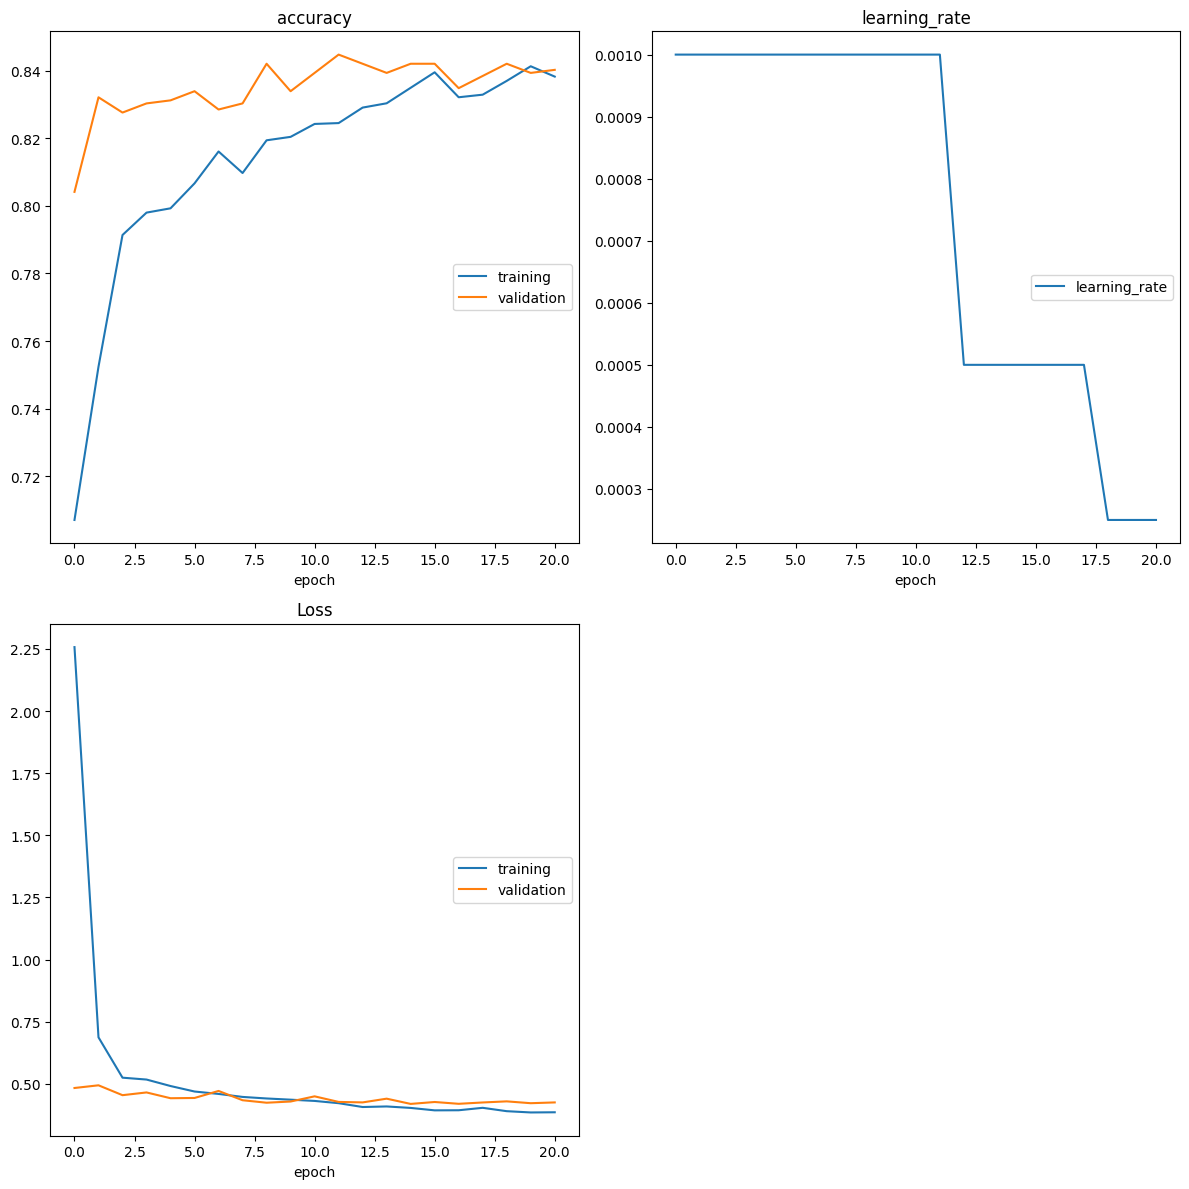

accuracy
	training         	 (min:    0.707, max:    0.841, cur:    0.838)
	validation       	 (min:    0.804, max:    0.845, cur:    0.840)
learning_rate
	learning_rate    	 (min:    0.000, max:    0.001, cur:    0.000)
Loss
	training         	 (min:    0.385, max:    2.257, cur:    0.386)
	validation       	 (min:    0.419, max:    0.494, cur:    0.425)
123/123 - 11s - 90ms/step - accuracy: 0.8383 - loss: 0.3857 - val_accuracy: 0.8403 - val_loss: 0.4253 - learning_rate: 2.5000e-04
Epoch 21: early stopping
Restoring model weights from the end of the best epoch: 15.


In [58]:
# Fit the model, if we haven't reloaded a previously-fitted one

if weights_file is None:

  history = model.fit(
                    train_datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=val_datagen.flow(X_val, y_val, batch_size=32),
                    epochs=50,
                    callbacks=[lr, es, mc, pl],
                    verbose=2
                    )

In [59]:
# Use the model to make predictions for the test data. As
# EarlyStopping.restore_best_weights=True, this should be the best model,
# not just the final epoch's one

y_prob, y_class = utils.get_predictions(model, X_test)
df = utils.collect_results(y_prob, y_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


In [60]:
# Generate sklearn classification report

print('\n', classification_report(y_test, y_class))


               precision    recall  f1-score   support

           0       0.85      0.96      0.90       429
           1       0.78      0.44      0.57       131

   micro avg       0.84      0.84      0.84       560
   macro avg       0.82      0.70      0.73       560
weighted avg       0.83      0.84      0.82       560
 samples avg       0.84      0.84      0.84       560



In [61]:
# Show some of the correctly- and incorrectly-classified images

utils.plot_classified_images(X_test, df)

Output hidden; open in https://colab.research.google.com to view.

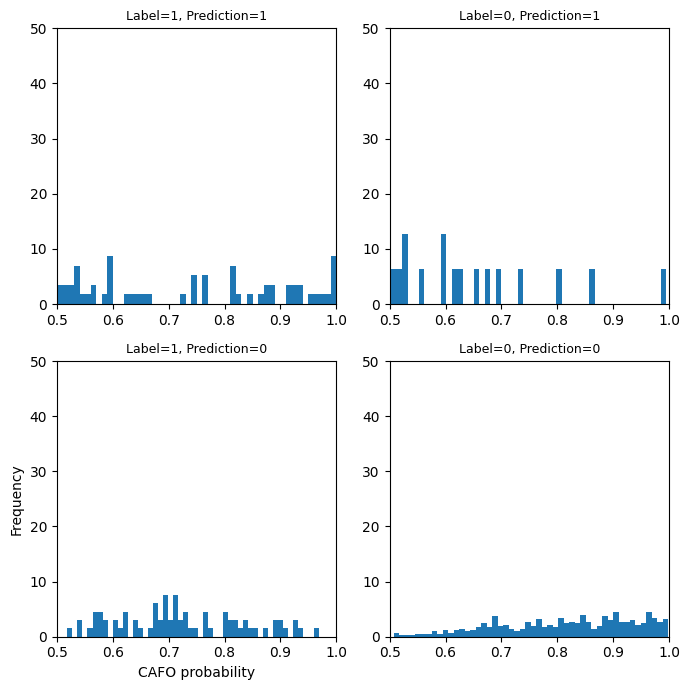

In [62]:
# Distribution of probabilities for correctly- and incorrectly-classified images

utils.probability_hist(df)

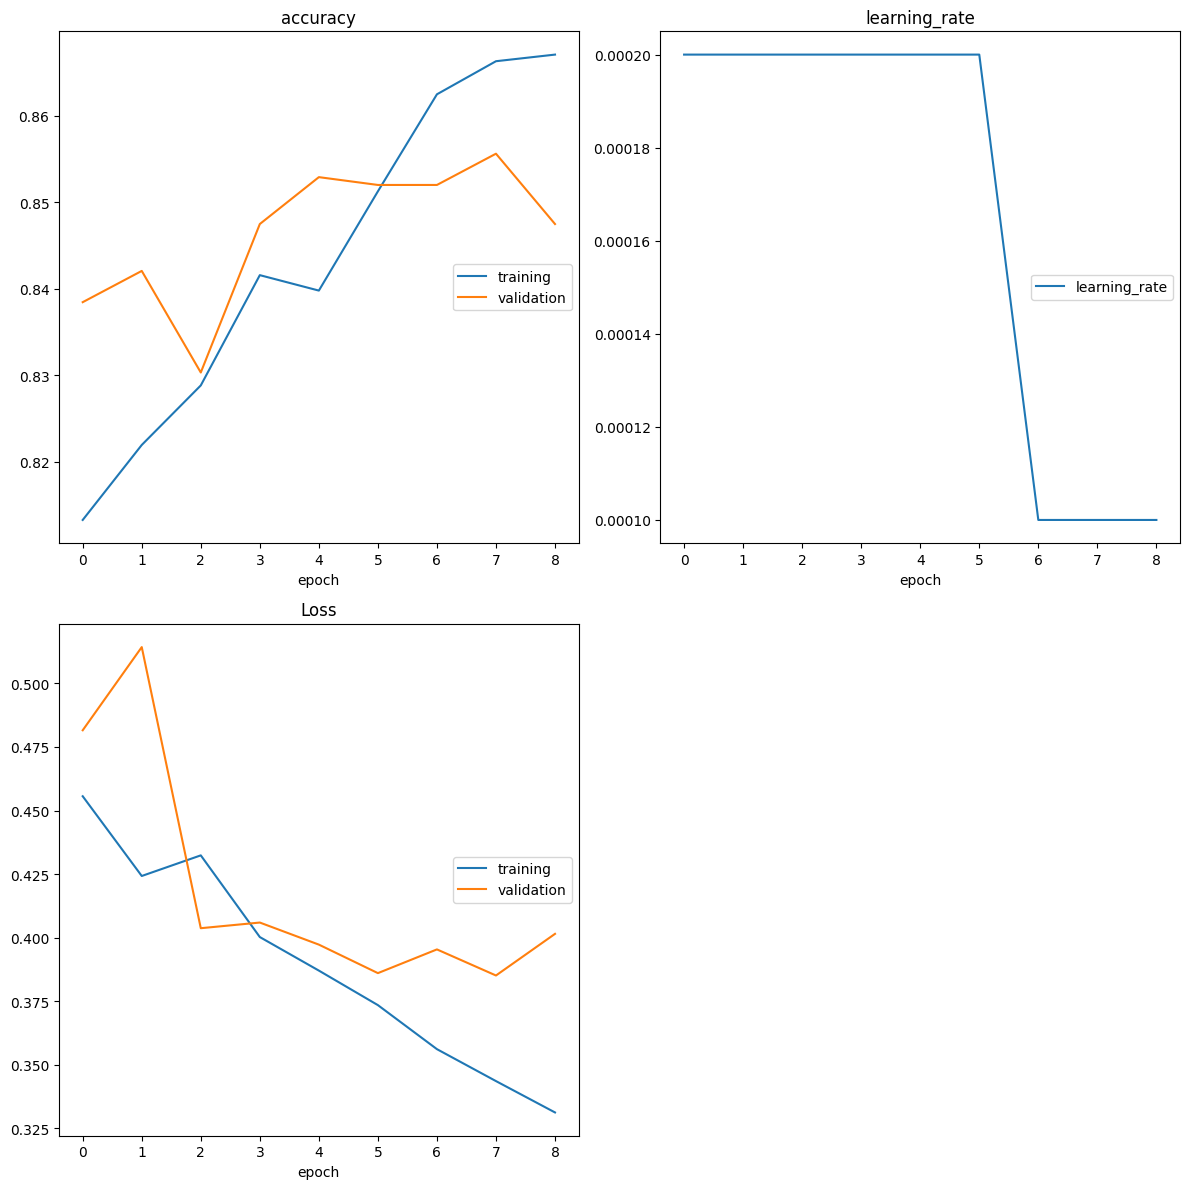

accuracy
	training         	 (min:    0.813, max:    0.867, cur:    0.867)
	validation       	 (min:    0.830, max:    0.856, cur:    0.847)
learning_rate
	learning_rate    	 (min:    0.000, max:    0.000, cur:    0.000)
Loss
	training         	 (min:    0.331, max:    0.456, cur:    0.331)
	validation       	 (min:    0.385, max:    0.514, cur:    0.402)
123/123 - 10s - 82ms/step - accuracy: 0.8670 - loss: 0.3313 - val_accuracy: 0.8475 - val_loss: 0.4015 - learning_rate: 1.0000e-04
Epoch 9: early stopping
Restoring model weights from the end of the best epoch: 3.


In [69]:
# Fine-tune the model

# Set the top few convolutional layers to be trainable
#  --- Do blocks not layers?
for layer in base_model.layers[-4:]:
    layer.trainable = True
    print(f"Layer {layer.name} is trainable")

# Compile the model with a lower learning rate
# Model compiling does not change weights; see
# stackoverflow.com/questions/47995324/does-model-compile-initialize-all-the-
# weights-and-biases-in-keras-tensorflow
optimizer=Adam(learning_rate=0.001*0.2)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Update parameters for Reduce LR and EarlyStopping to reduce overfitting
lr = ReduceLROnPlateau(
                      factor=0.5,
                      monitor='val_loss',
                      min_delta=0.03,
                      patience=3,
                      min_lr=1e-6,
                      verbose=2
                      )

es = EarlyStopping(
                  monitor='val_loss',
                  mode='min',
                  restore_best_weights=True,
                  min_delta=0.03,
                  patience=6,
                  verbose=2
                  )

# Specify a new filename for best model
mc = ModelCheckpoint(
                    '/content/drive/MyDrive/CAFO_models/VGG16_step2.keras',
                    monitor='val_accuracy',
                    mode='max',
                    verbose=2,
                    save_best_only=True
                    )

# Reset the plots
pl = PlotLossesCallback()

# Uncomment if this fine-tuning step is interrupted and restarted
# Otherwise fitting will presumably continue with most recent weights
#weights_file = '/content/drive/MyDrive/CAFO_models/VGG16_step1.keras'
#model.load_weights(weights_file)

# Fit the model
ft_history = model.fit(
                    train_datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=val_datagen.flow(X_val, y_val, batch_size=32),
                    epochs=70, #base epochs + fine-tuning ones?
                    callbacks=[lr, mc, es, pl],
                    verbose=2
                    )

In [70]:
y_prob_ft, y_class_ft = utils.get_predictions(model, X_test)

df_ft = utils.collect_results(y_prob_ft, y_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


In [71]:
print('\n', classification_report(y_test, y_class_ft))


               precision    recall  f1-score   support

           0       0.81      1.00      0.89       429
           1       0.93      0.21      0.35       131

   micro avg       0.81      0.81      0.81       560
   macro avg       0.87      0.60      0.62       560
weighted avg       0.84      0.81      0.76       560
 samples avg       0.81      0.81      0.81       560



In [72]:
utils.plot_classified_images(X_test, df_ft)

Output hidden; open in https://colab.research.google.com to view.

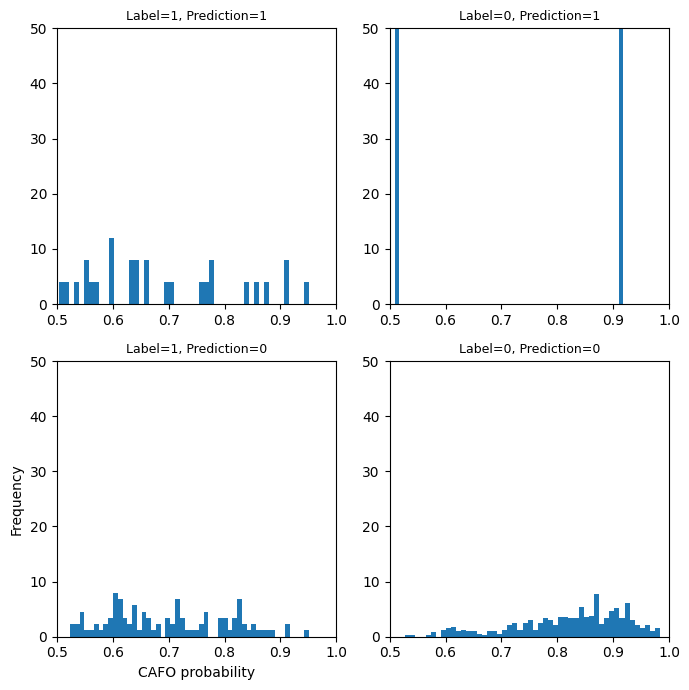

In [73]:
utils.probability_hist(df_ft)